In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pyspark

In [43]:
# Data Preparation
feedback = pd.read_csv("chatjoin.csv", encoding='latin1')
score = pd.read_csv("enrolments.csv")
submission = pd.read_csv("submissions.csv")
feedback.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21457 entries, 0 to 21456
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         21457 non-null  object
 1   id              21457 non-null  int64 
 2   created_at      21457 non-null  int64 
 3   content         21457 non-null  object
 4   was_student     21457 non-null  bool  
 5   already_passed  21457 non-null  bool  
 6   post_type       21457 non-null  object
dtypes: bool(2), int64(2), object(3)
memory usage: 880.2+ KB


In [44]:
score.head()

,user_id,created_at,assigned_at,slug,role,is_tutor,grade,gender,score,coursebookmark,institution_id
0,3f2464ce24df9e5e3f7df227aea411b5,1529292116,NaN,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,59bc1e61f0353ee2e87647ceda3e9768
1,3a3941985aa58cd20b2ec38cddcf01e5,1535429753,1.535430e+09,challenge-beginners-2018,PROFESSIONAL,True,NaN,NaN,0,False,d8ada80be429ecebca5340c31efcf718
2,d4e515deddd650591b0e9a729fcd08ac,1533513298,NaN,challenge-beginners-2018,STUDENT,False,11.0,NaN,190,False,e1de43293d8bb9726f00ee2f1ce8bce3
3,f3f688d53d9995b4cee250348677431b,1529358771,NaN,challenge-beginners-2018,STUDENT,False,7.0,F,0,True,c55e2534bcdae7a4bf4c64b9a7a93a25
4,8a3c2b039ebf6fde09f598b75a31d73f,1533517799,NaN,challenge-beginners-2018,STUDENT,False,7.0,M,120,False,3e8fac6ee60765f7281c161a6d185838


In [45]:
# merge two dataset
data = feedback.merge(score, on="user_id", how="outer")
data = data.merge(submission, on='user_id', how="outer")
data.head()

,user_id,id_x,created_at_x,content,was_student,already_passed_x,post_type,created_at_y,assigned_at,slug,...,score,coursebookmark,institution_id,id_y,created_at,status,files,results,failed_label,already_passed_y
0,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,410.0,False,f348e78bf7c7ae9a0f962d92fa72dc85,10149525.0,1.533724e+09,PASSED,"[{'content': ""from turtle import *\ndirection ...",NaN,NaN,False
1,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,410.0,False,f348e78bf7c7ae9a0f962d92fa72dc85,9821612.0,1.533093e+09,PASSED,"[{'content': ""from turtle import *\nforward(30...",NaN,NaN,False
2,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,410.0,False,f348e78bf7c7ae9a0f962d92fa72dc85,9820172.0,1.533092e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg2 - cliff,False
3,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,410.0,False,f348e78bf7c7ae9a0f962d92fa72dc85,9820132.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False
4,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,410.0,False,f348e78bf7c7ae9a0f962d92fa72dc85,9819984.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False


In [46]:
print(data.dtypes)

user_id              object
id_x                float64
created_at_x        float64
content              object
was_student          object
already_passed_x     object
post_type            object
created_at_y        float64
assigned_at         float64
slug                 object
role                 object
is_tutor             object
grade               float64
gender               object
score               float64
coursebookmark       object
institution_id       object
id_y                float64
created_at          float64
status               object
files                object
results              object
failed_label         object
already_passed_y     object
dtype: object


In [50]:
# RQ1
data['feedbackReceived'] = 0  # Initialize the column with 0

# Group the data by user_id and apply the conditions within each group
grouped = data.groupby('user_id')
for _, group in grouped:
    if group['content'].notnull().any() and not group['was_student'].all():
        data.loc[group.index, 'feedbackReceived'] = 1

data

,user_id,id_x,created_at_x,content,was_student,already_passed_x,post_type,created_at_y,assigned_at,slug,...,coursebookmark,institution_id,id_y,created_at,status,files,results,failed_label,already_passed_y,feedbackReceived
0,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,False,f348e78bf7c7ae9a0f962d92fa72dc85,10149525.0,1.533724e+09,PASSED,"[{'content': ""from turtle import *\ndirection ...",NaN,NaN,False,1
1,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,False,f348e78bf7c7ae9a0f962d92fa72dc85,9821612.0,1.533093e+09,PASSED,"[{'content': ""from turtle import *\nforward(30...",NaN,NaN,False,1
2,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,False,f348e78bf7c7ae9a0f962d92fa72dc85,9820172.0,1.533092e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg2 - cliff,False,1
3,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,False,f348e78bf7c7ae9a0f962d92fa72dc85,9820132.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False,1
4,65f59a3a9e7f38f1d65f277d533502ce,249483.0,1.533724e+09,Thank you!,True,True,MESSAGE,1.532938e+09,1.532938e+09,challenge-beginners-2018,...,False,f348e78bf7c7ae9a0f962d92fa72dc85,9819984.0,1.533091e+09,FAILED,[{'content': 'from turtle import *\nforward(30...,"[{'status': 0, 'data': {'message': ''}, 'type'...",eg1 - cliff,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613028,9188a9cb2bef098089d5f45e066df518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9849341.0,1.533128e+09,FAILED,"[{'content': ""first = input('What is the first...","[{'status': 0, 'msg': 'Testing the words in th...",match - words,False,0
1613029,9188a9cb2bef098089d5f45e066df518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9849223.0,1.533127e+09,PASSED,"[{'content': ""name = input('What name? ')\npri...",NaN,NaN,False,0
1613030,9188a9cb2bef098089d5f45e066df518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,9849214.0,1.533127e+09,FAILED,"[{'content': ""name = input('What name? ')\npri...","[{'status': 0, 'msg': 'Testing that the words ...",Stage name words,False,0
1613031,2635cbc50cf2f3f4c7fcdadfa290ada1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10495206.0,1.534472e+09,PASSED,"[{'content': ""from turtle import *\n\nnumber =...",NaN,NaN,False,0


In [58]:
reduced = data[["user_id", "grade", "feedbackReceived"]].copy().groupby("user_id").first().reset_index()
reduced

,user_id,grade,feedbackReceived
0,0008c93cbc047666cab8ec9b06e7fb43,9.0,1
1,00093daf36073e2aeb7b2723135c21d1,9.0,0
2,000b51052a5e303dcefc14e077044865,9.0,1
3,000c11bdc5aa25d11cb9d5c7b268b13b,5.0,0
4,0017e1dfb8022a9cc4376edf1a72249d,7.0,0
...,...,...,...
12901,ffe7b69c70d4435b15b442760ec1e7cf,9.0,1
12902,ffeb3e0e0a721e8bc574d0c292d4b772,6.0,0
12903,fff3d648f1878a34a52634d07d3c2694,9.0,0
12904,fff717aeb51d6b58be1e7168eecbb7f0,9.0,0


In [60]:
correlation = data[['score', 'grade', 'feedbackReceived']].corr(method='spearman')

print(correlation)

                     score     grade  feedbackReceived
score             1.000000  0.067464          0.159806
grade             0.067464  1.000000         -0.158444
feedbackReceived  0.159806 -0.158444          1.000000


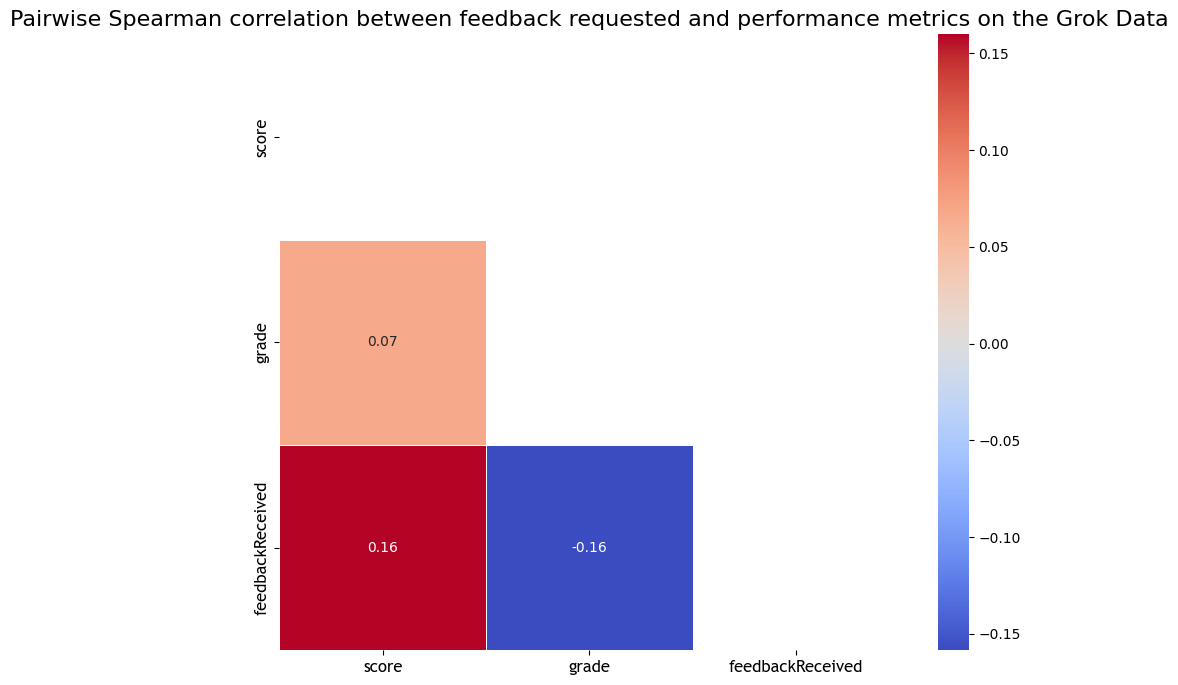

In [63]:
# # Create a mask for upper triangular portion
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a correlation heatmap with improved theme
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)

# Set the title of the plot
plt.title('Pairwise Spearman correlation between feedback requested and performance metrics on the Grok Data', fontsize=16)

# # Customize the colorbar
# cbar = plt.colorbar()
# cbar.ax.tick_params(labelsize=12)

# Set the font size of the annotations
plt.xticks(fontsize=12, fontfamily="Trebuchet MS")
plt.yticks(fontsize=12, fontfamily="Trebuchet MS")

# Display the plot
plt.show()